# Analisi di un catalogo di ammassi di galassie

L'esercizio consiste nell'analizzare un catalogo di ammassi di galassie (`euclid_clusters.csv`) con caratteristiche simili a quelli che saranno osservati dalla missione Euclid. Il catalogo fornisce la massa (in masse solari) per ogni ammasso, per tre bin di redshift, ed il volume di universo associato a ciascun bin (in ${Mpc}^3/h^3$).

### Pacchetti e librerie utilizzati

In [3]:
import pandas as pd
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
import numpy as np

## Parte uno: visualizzazione e analisi dei dati

_Scaricare il catalogo degli ammassi di galassie e analizzarne i dati, prestando particolare attenzione alla distribuzione delle masse degli ammassi. Si suggerisce di utilizzare scale logaritmiche per verificare la distribuzione dei dati._

Per prima cosa importo i dati del catalogo su un dataframe. <br/>
Tengo conto dell'indicizzazione della prima colonna specificando l'argomento `index_col = 0`.

In [47]:
# importing data-frame 
euclid_clusters = pd.read_csv("euclid_clusters.csv", index_col = 0)

# checking goodness of dataframe
euclid_clusters.head()

,mass,z,vol
0,1.060613e+14,0.506,1.479387e+10
1,1.097076e+14,0.506,1.479387e+10
2,1.588869e+14,0.506,1.479387e+10
3,1.336345e+14,0.506,1.479387e+10
4,3.078288e+14,0.506,1.479387e+10


Dopo aver importato il dataframe ed essermi assicurato che venga rappresentato correttamente, effettuo una prima analisi dei dati con la funzione `.hist()`. <br/>

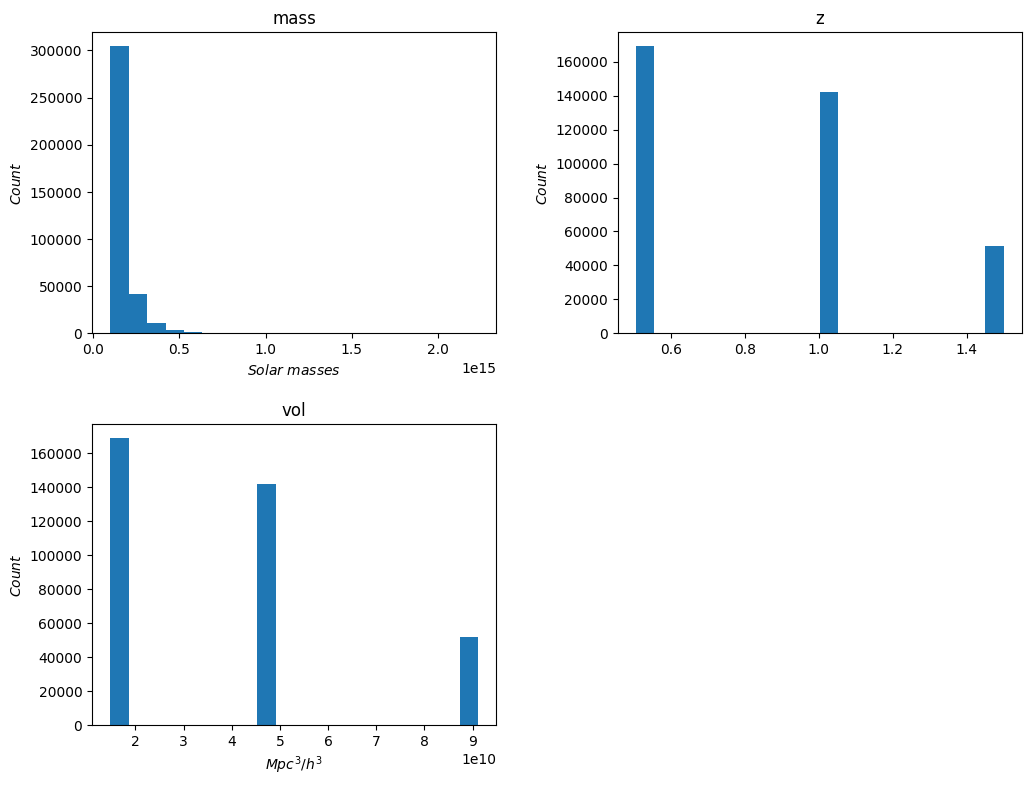

In [8]:
# plotting histograms for each column
axes = euclid_clusters.hist(grid = False, bins = "sturges", figsize = (12, 9))
axes[0][0].set_xlabel("$Solar\ masses$")
axes[1][0].set_xlabel("${Mpc}^3/h^3$")
for ax in axes.flatten():
    ax.set_ylabel("$Count$")
plt.show()

I precedenti istogrammi permettono di trarre una serie di conclusioni:

1. qualitativamente la distribuzione delle masse segue una decrescita esponenziale;
2. i tre bin di redshift non contengono lo stesso numero di ammassi di galassie;
3. il numero di galassie per ogni bin decresce con la distanza e con il volume occupato.

In particolare, la 1. giustifica il passaggio alle scale logaritmiche per studiare la distribuzione dei dati, mentre la 3. mi permette di concludere che il volume di universo associato ad ogni bin di redshift è inversamente proporzionale al redshift stesso.

In scala logaritmica, l'andamento delle masse appare lineare.

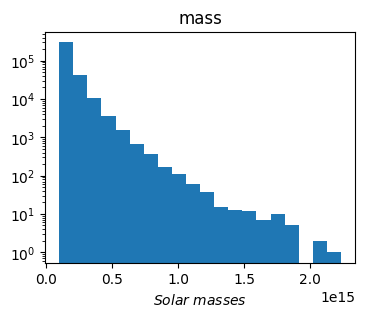

In [56]:
euclid_clusters.hist(["mass"], grid = False, bins = "sturges", figsize = (4, 3), log = True)
plt.xlabel("$Solar\ masses$")
plt.show()

Supponendo che le masse seguano effettivamente una distribuzione esponenziale del tipo
\begin{equation}
    f(x) = \lambda e^{-\lambda x}\ , 
\end{equation}
il metodo della massima verosimiglianza mi permette di stimare $\lambda$ utilizzando l'inverso della media aritmetica. Posso quindi procedere a sovrapporre il grafico di $f(x)$ all'istogramma normalizzato.

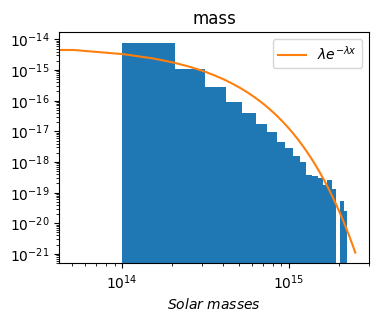

In [114]:
# defining distribution and estimating parameter
def f(x, l):
    return l * np.exp(-l*x)
l = 1/euclid_clusters["mass"].mean()

# plotting graph over histogram
euclid_clusters.hist(["mass"], grid = False, bins = "sturges", figsize = (4, 3), density = True)
x = np.linspace(0, 2.5e15)
plt.plot(x, f(x, l), label = r"$\lambda e^{-\lambda x}$")
plt.xlabel("$Solar\ masses$")
plt.legend()
plt.loglog()
plt.show()

Concludo così che graficamente l'andamento delle masse nel catalogo è in buon accordo con una distribuzione esponenziale.

## Parte due: analisi della Halo Mass Function (HMF)
_Analizzare ogni bin di redshift individualmente e confrontare la distribuzione osservata delle masse degli ammassi (Halo Mass Function, HMF) con la distribuzione teorica predetta da diversi parametri cosmologici per verificarne la dipendenza._

Come suggerito, utilizzo la libreria Colossus. <br/>
Inizializzo i parametri cosmologici (`params`) e imposto la cosmologia come nel frammento di codice dato.

In [20]:
# initializing cosmological parameters
params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.96}

# setting cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

Per lavorare con ogni bin separatamente suddivido il dataframe originale in tre sottinsiemi in base al redshift:
 - `z1` = 0.506;
 - `z2` = 1.019;
 - `z3` = 1.500.

Per la suddivisione utilizzo gli indici ricavati nella prima parte del notebook:

In [22]:
# creating subframes
z1 = euclid_clusters.iloc[:168897]
z2 = euclid_clusters.iloc[168897:310904]
z3 = euclid_clusters.iloc[310904:]

La libreria Colossus mi permette di calcolare le distribuzioni cumulative della densità di aloni osservati (`mfunc`), dato un redshift z. La densità è espressa in masse solari per unità di volume osservato (in ${Mpc}^3/h^3$) per bin logaritmico naturale di massa. <br/>
Nell'immagine si possono visualizzare le predizioni per ogni redshift.

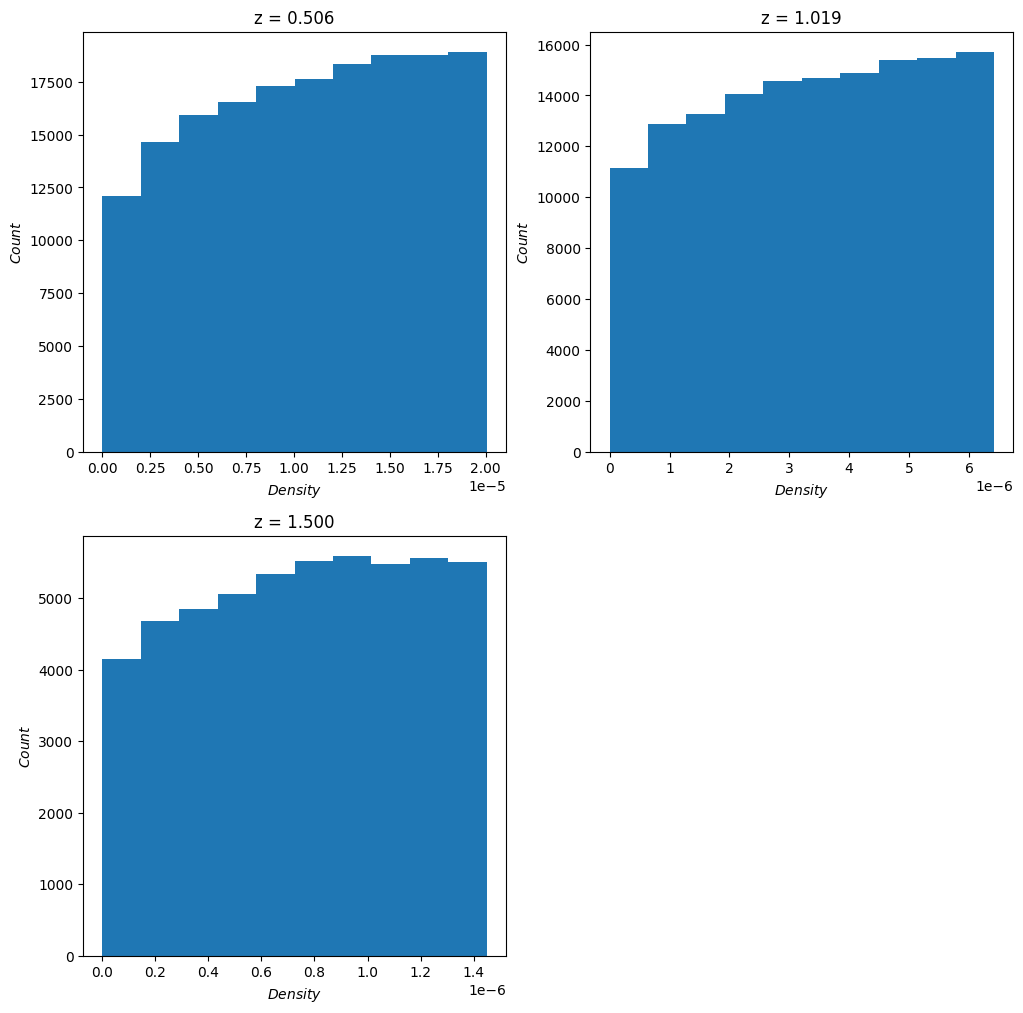

In [24]:
# calculating theoretical cumulative distributions
mfunc1 = mass_function.massFunction(z1['mass'], 0.506, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
mfunc2 = mass_function.massFunction(z2['mass'], 1.019, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
mfunc3 = mass_function.massFunction(z3['mass'], 1.500, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

# sketching the cumulative distributions
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
axes[0, 0].hist(mfunc1)
axes[0, 0].set_title('z = 0.506')
axes[0, 1].hist(mfunc2)
axes[0, 1].set_title('z = 1.019')
axes[1, 0].hist(mfunc3)
axes[1, 0].set_title('z = 1.500')
fig.delaxes(axes[1, 1])
for ax in axes.flat:
    ax.set(xlabel = '$Density$', ylabel='$Count$')

## Parte tre: inferenza bayesiana sui parametri cosmologici

### Modelli flat $\Lambda CDM$
_Supponendo che le predizioni teoriche della HMF siano in accordo con i dati osservati, si può procedere con una fase di inferenza bayesiana sui parametri cosmologici._ 

_Analizzare inizialmente i tre bin di redshift individualmente. Ha senso combinarli per un'analisi congiunta?_